In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

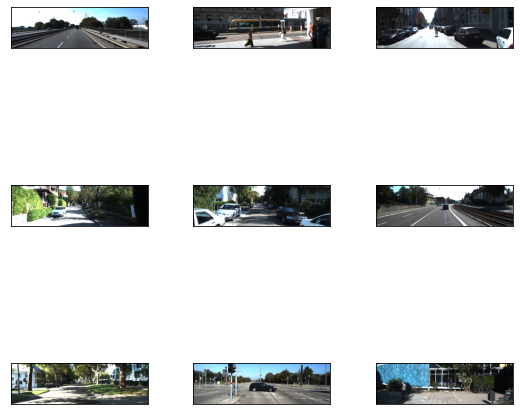

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(6,), dtype=float32, numpy=array([-1.55,  1.73,  1.66, -2.08, -2.13, -2.36], dtype=float32)>, 'bbox': <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0.39458665, 0.4565298 , 0.5318933 , 0.49937198],
       [0.43896   , 0.3834058 , 0.5218933 , 0.41460547],
       [0.48378667, 0.42907408, 0.52650666, 0.44611916],
       [0.47938666, 0.7707971 , 0.5593867 , 0.8343961 ],
       [0.47322667, 0.8202335 , 0.6017867 , 0.9212802 ],
       [0.45064   , 0.99513686, 0.63597333, 0.99919486]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1.61, 1.66, 3.2 ],
       [1.66, 1.61, 3.46],
       [1.49, 1.67, 4.38],
       [1.36, 1.5 , 4.21],
       [1.78, 1.87, 4.98],
       [1.97, 2.16, 5.31]], dtype=float32)>, 'location': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[-0.57,  1.72, 24.4 ],
       [-6.42,  2.03, 40.59],
       [-6.45,  1.97

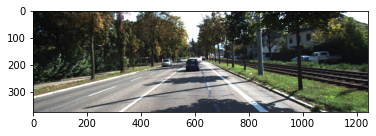

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

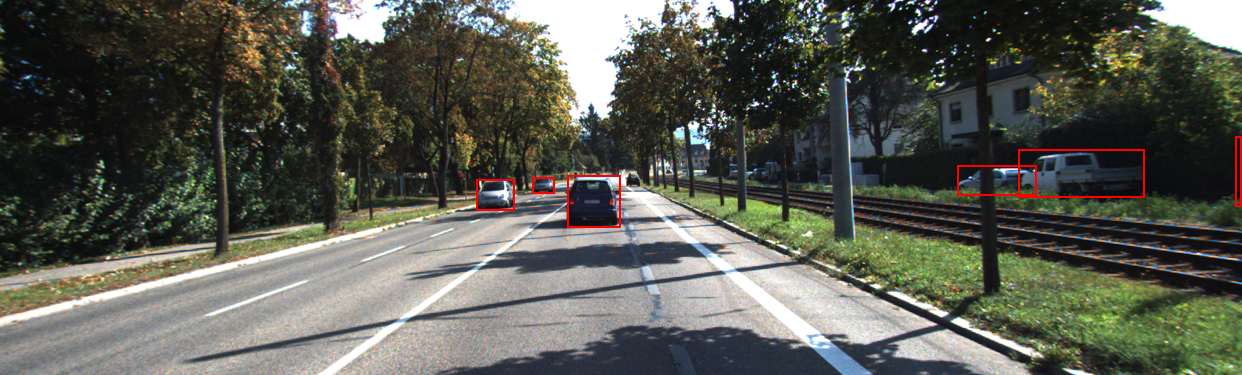

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [7]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [8]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [9]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


In [10]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


In [11]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id


In [12]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)


In [13]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


In [14]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()


In [15]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


In [16]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [17]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [18]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [19]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss


In [20]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 1s 0us/step


In [21]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [22]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)


model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints1/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 20

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)


Epoch 1/20
3173/3173 [==============================] - 1633s 514ms/step - loss: 0.9814 - val_loss: 1.2251

Epoch 00001: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_1
Epoch 2/20
3173/3173 [==============================] - 1636s 515ms/step - loss: 0.7175 - val_loss: 1.0926

Epoch 00002: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_2
Epoch 3/20
3173/3173 [==============================] - 1635s 515ms/step - loss: 0.5732 - val_loss: 1.0553

Epoch 00003: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_3
Epoch 4/20
3173/3173 [==============================] - 1635s 515ms/step - loss: 0.4789 - val_loss: 1.0637

Epoch 00004: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_4
Epoch 5/20
3173/3173 [==============================] - 1635s 515ms/step - loss: 0.4052 - val_loss: 0.9914

Epoch 00005: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_5
Epoch 6/20
3173/3173 [==============================] - 1634s 515ms/step - loss: 0.3480 - val_loss: 0.9786

Epoch 00006: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_6
Epoch 7/20
3173/3173 [==============================] - 1635s 515ms/step - loss: 0.3014 - val_loss: 0.9719

Epoch 00007: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_7
Epoch 8/20
3173/3173 [==============================] - 1634s 514ms/step - loss: 0.2652 - val_loss: 1.0689

Epoch 00008: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_8
Epoch 9/20
3173/3173 [==============================] - 1634s 515ms/step - loss: 0.2352 - val_loss: 0.9889

Epoch 00009: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_9
Epoch 10/20
3173/3173 [==============================] - 1638s 515ms/step - loss: 0.2089 - val_loss: 1.0126

Epoch 00010: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_10
Epoch 11/20
3173/3173 [==============================] - 1639s 514ms/step - loss: 0.1847 - val_loss: 1.0013

Epoch 00011: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_11
Epoch 12/20
3173/3173 [==============================] - 1639s 515ms/step - loss: 0.1691 - val_loss: 1.0248

Epoch 00012: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_12
Epoch 13/20
3173/3173 [==============================] - 1637s 514ms/step - loss: 0.1575 - val_loss: 1.0234

Epoch 00013: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_13
Epoch 14/20
3173/3173 [==============================] - 1643s 516ms/step - loss: 0.1364 - val_loss: 1.0671

Epoch 00014: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_14
Epoch 15/20
3173/3173 [==============================] - 1638s 514ms/step - loss: 0.1290 - val_loss: 1.0483

Epoch 00015: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_15
Epoch 16/20
3173/3173 [==============================] - 1643s 516ms/step - loss: 0.1151 - val_loss: 1.0626

Epoch 00016: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_16
Epoch 17/20
3173/3173 [==============================] - 1641s 514ms/step - loss: 0.1038 - val_loss: 1.0601

Epoch 00017: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_17
Epoch 18/20
3173/3173 [==============================] - 1640s 515ms/step - loss: 0.1009 - val_loss: 1.0451

Epoch 00018: saving model to /aiffel/aiffel/object_detection/data/checkpoints1/weights_epoch_18
Epoch 19/20
3173/3173 [==============================] - ETA: 0s - loss: 0.0929


checkpoints1 로 저장후 사용 하였습니다.




/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0, flags=flags)


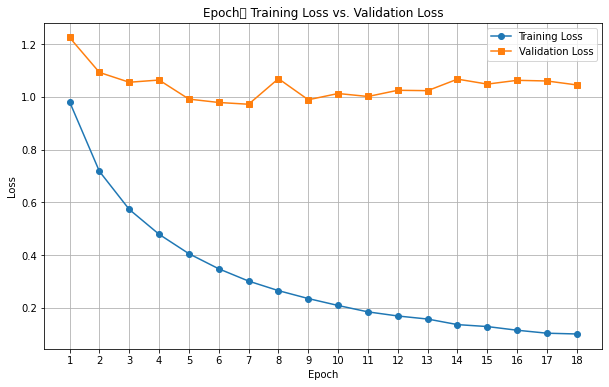

In [35]:
import matplotlib.pyplot as plt

# 에포크 번호
epochs = list(range(1, 19))

# 에포크별 training loss 값
train_loss = [
    0.9814, 0.7175, 0.5732, 0.4789, 0.4052, 0.3480, 0.3014, 0.2652,
    0.2352, 0.2089, 0.1847, 0.1691, 0.1575, 0.1364, 0.1290, 0.1151,
    0.1038, 0.1009
]

# 에포크별 validation loss 값
val_loss = [
    1.2251, 1.0926, 1.0553, 1.0637, 0.9914, 0.9786, 0.9719, 1.0689,
    0.9889, 1.0126, 1.0013, 1.0248, 1.0234, 1.0671, 1.0483, 1.0626,
    1.0601, 1.0451
]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.title('Epoch별 Training Loss vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()


In [23]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints1/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [24]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [25]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [26]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax


In [27]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

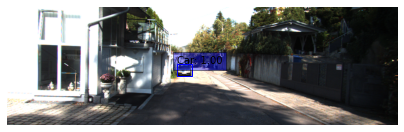

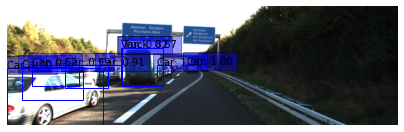

In [29]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )


# 1. 자율주행 시스템 만들기
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

입력으로 이미지 경로를 받습니다.
정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
조건은 다음과 같습니다.

1. 사람이 한 명 이상 있는 경우
2. 차량의 크기(width or height)가 300px이상인 경우

조건에 대한 의문점

사람이 보도에 있어도 서야되나? 

차량이 가까울 때를 대비해서 이런식으로 조건을 단건가?

Car: 일반 승용차를 의미합니다.
Van: 밴 또는 소형 승합차로, Car와 비슷하지만 크기나 구조에서 차이가 있습니다.
Truck: 대형 트럭 또는 화물차를 의미합니다.
Pedestrian: 보행자, 즉 길을 걷는 사람을 의미합니다.
Person_sitting: 앉아 있는 사람을 의미합니다. 주로 차량이나 다른 구조물에 앉아있는 경우를 구분하기 위해 사용됩니다.
Cyclist: 자전거를 타고 있는 사람을 의미합니다.
Tram: 전차를 의미하며, 도시 내에서 운행되는 전기 철도 차량입니다.
Misc: 위의 범주에 속하지 않는 기타 객체를 의미합니다.
DontCare: 평가 시 무시해도 되는 영역 또는 객체를 의미합니다. 이 클래스는 보통 애매하게 분류되거나 평가에 포함시키지 않아도 되는 객체들을 나타냅니다.

데이터셋 type의 대한 설명입니다.

Car, Van은 일반적으로 보아서 처리하나 만약에 트럭일 경우에는 차량의 크기 조건을 좀 더 크게 할 필요가 있지 않을까?

Person_sitting 같은 경우에는 무시해도 되지 않을까? -> 무시해야 할꺼같다. 차에 앉아있을 경우에도 포함이 되기 떄문에?

Pedestrian 중에서 인도를 걷는 경우에는 무시해도 되지 않을까?

Cyclist 자전거를 타는 사람들은 어떻게 해야할까? 

어떠한 기준으로 DontCare를 하고 Misc중에서 신경써야 될 것들이 있지 않을까?

음 사실 이러한 단순한 조건으로 stop and go는 큰 의미가 없으나 요구사항이 정해졌으니 이에 맞춰서 해보겠습니다!


In [55]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

import os
import numpy as np
import tensorflow as tf
from PIL import Image

LABEL_MAP = {
    0: "Car",
    1: "Van",
    2: "Truck",
    3: "Pedestrian",
    4: "Person_sitting",
    5: "Cyclist",
    6: "Tram",
    7: "Misc",
    8: "DontCare"
}

#person_sitting은 무시하는 것이 더 좋아보인다고 생각된다.

# 사람이 포함된 클래스 
PERSON_LABELS = {"pedestrian","Cyclist"}

# 차량으로 간주할 클래스 
VEHICLE_LABELS = {"car", "truck", "bus", "van", "tram"}

def self_drive_assist(image_path):
    """
    입력 이미지 경로에 대해 객체 검출을 수행하여
    1) 사람이 한 명 이상 있거나,
    2) 차량의 bbox width 또는 height가 300px 이상이면
    "Stop"을 반환하고, 아니면 "Go"를 반환합니다.
    """
    # 이미지 로드 및 RGB 변환
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # 이미지 전처리 
    input_tensor, ratio = prepare_image(image_np)  

    detections = inference_model.predict(input_tensor)
    nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections = detections

    num_detections = int(valid_detections[0])
    for i in range(num_detections):
        score = nmsed_scores[0][i]
        # 낮은 신뢰도 무시 
        if score < 0.5:
            continue

        cls_id = int(nmsed_classes[0][i])
        # 클래스 인덱스를 문자열로 변환한 후 소문자로 비교
        label = LABEL_MAP.get(cls_id, "unknown").lower()
        
        # 바운딩 박스 좌표 (x1, y1, x2, y2)
        box = nmsed_boxes[0][i]
        width = box[2] - box[0]
        height = box[3] - box[1]
        
        # 조건 1: 사람이 검출된 경우
        if label in PERSON_LABELS:
            return "Stop"
        
        # 조건 2: 차량이며 bbox의 width 또는 height가 300px 이상인 경우
        if label in VEHICLE_LABELS and (width >= 300 or height >= 300):
            return "Stop"
    
    return "Go"





# 2. 자율주행 시스템 평가하기

아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 

10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [56]:
import os

def test_system_verbose(func):
    work_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
    score = 0
    test_set = [
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = os.path.join(work_dir, image_file)
        pred = func(image_path)
        if pred == answer:
            result = "PASS"
            score += 10
        else:
            result = "FAIL"
        print(f"Image: {image_file}, Prediction: {pred}, Expected: {answer} => {result}")
    
    print(f"최종 점수: {score}점입니다.")

test_system_verbose(self_drive_assist)


Image: stop_1.png, Prediction: Stop, Expected: Stop => PASS
Image: stop_2.png, Prediction: Stop, Expected: Stop => PASS
Image: stop_3.png, Prediction: Stop, Expected: Stop => PASS
Image: stop_4.png, Prediction: Stop, Expected: Stop => PASS
Image: stop_5.png, Prediction: Stop, Expected: Stop => PASS
Image: go_1.png, Prediction: Go, Expected: Go => PASS
Image: go_2.png, Prediction: Go, Expected: Go => PASS
Image: go_3.png, Prediction: Go, Expected: Go => PASS
Image: go_4.png, Prediction: Go, Expected: Go => PASS
Image: go_5.png, Prediction: Go, Expected: Go => PASS
최종 점수: 100점입니다.


프로젝트에서 목표로 하는 1차적인 목표를 달성하였습니다.

조금 더 확인해보고 싶은것들 : 

1. localization과 detection의 loss를 따로 값비교를 해보기?

2. 테스트 표본이 너무 적어서 이 모델이 잘 되고 있는지 잘모르겠다. -> 더 많은 표본에서 제대로 검출 되는지 확인해 봅시다.

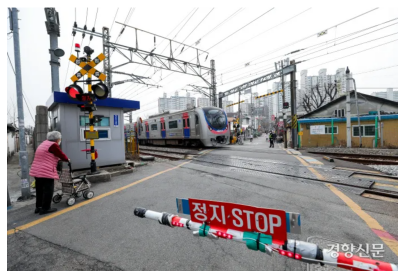

Image: stop_6.png, Prediction: Go, Expected: Stop => FAIL


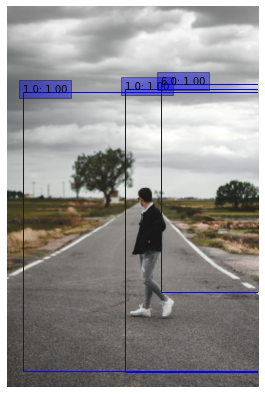

Image: stop_7.PNG, Prediction: Stop, Expected: Stop => PASS


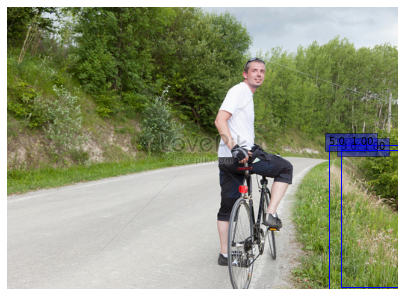

Image: stop_8.PNG, Prediction: Stop, Expected: Stop => PASS


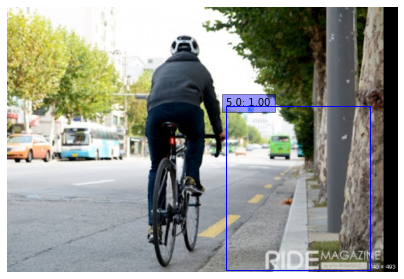

Image: stop_9.PNG, Prediction: Go, Expected: Stop => FAIL


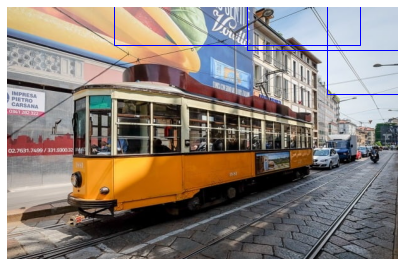

Image: stop_10.PNG, Prediction: Stop, Expected: Stop => PASS


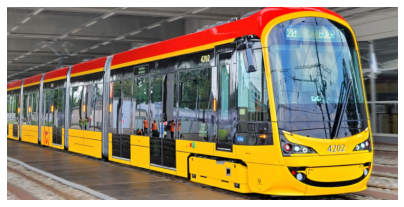

Image: stop_11.PNG, Prediction: Stop, Expected: Stop => PASS


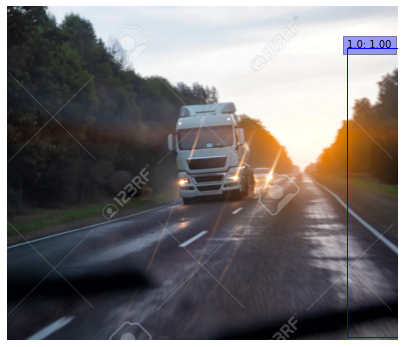

Image: stop_12.PNG, Prediction: Stop, Expected: Stop => PASS


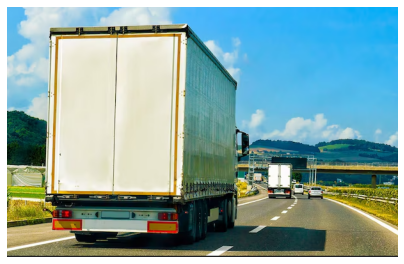

Image: stop_13.PNG, Prediction: Go, Expected: Stop => FAIL
최종 점수: 50점입니다.


In [64]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# inference_model, prepare_image, visualize_detections, LABEL_MAP는 이미 정의되었다고 가정합니다.

def inference_on_image(model, image_path):
    """
    주어진 이미지 파일 경로에 대해 inference_model을 사용하여
    객체 검출 결과(바운딩 박스, 클래스)를 반환하는 함수입니다.
    """
    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    input_tensor, ratio = prepare_image(image_np)  # prepare_image는 모델 입력에 맞게 전처리합니다.
    
    # 모델 추론: inference_model은 DecodePredictions까지 연결된 최종 모델입니다.
    detections = inference_model.predict(input_tensor)
    # detections 구성: [nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections]
    nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections = detections
    num_detections = int(valid_detections[0])
    boxes = nmsed_boxes[0][:num_detections]
    # 여기서는 점수는 사용하지 않고, 클래스 정보만 반환합니다.
    classes = nmsed_classes[0][:num_detections]
    return boxes, classes

def self_drive_assist(img_path, size_limit=300):
    """
    이미지 파일 경로를 입력받아, 객체 검출 결과를 기반으로 조건에 따라 "Stop" 또는 "Go"를 반환합니다.
    
    조건:
      1. 'Pedestrian' 또는 'Person_sitting' (소문자 비교)이 검출되면 "Stop"
      2. 차량 (예: 'Car', 'Van', 'Truck', 'Tram') 중 bbox의 width 또는 height가 size_limit 이상이면 "Stop"
      3. 그 외에는 "Go"
    
    또한, 해당 이미지의 검출 결과를 시각화합니다.
    """
    # inference_on_image를 통해 바운딩 박스와 클래스 정보 가져오기
    boxes, classes = inference_on_image(model, img_path)
    decision = "Go"
    for box, cls in zip(boxes, classes):
        label = LABEL_MAP.get(int(cls), "unknown").lower()  # 소문자 변환
        width = abs(box[2] - box[0])
        height = abs(box[3] - box[1])
        # 조건 1: 보행자 관련 클래스
        if label in {"pedestrian", "person_sitting"}:
            decision = "Stop"
            break
        # 조건 2: 차량이며 bbox 크기가 지정한 size_limit 이상인 경우
        if label in {"car", "van", "truck", "tram"} and (width >= size_limit or height >= size_limit):
            decision = "Stop"
            break
    
    # 시각화: 이미지 위에 검출 결과와 결정 결과를 표시합니다.
    image = Image.open(img_path).convert("RGB")
    image_np = np.array(image)
    # visualize_detections 함수는 (image, boxes, classes, scores)를 입력받습니다.
    # 여기서는 scores가 정의되어 있지 않으므로, 임의로 1.0의 값을 각 객체에 할당합니다.
    dummy_scores = [1.0] * len(boxes)
    ax = visualize_detections(image_np, boxes, classes, dummy_scores)
    ax.set_title(f"Decision: {decision}")
    plt.show()
    
    return decision

def test_system_verbose(func):
    work_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'object_detection', 'data')
    score = 0
    test_set = [
        ("stop_6.png", "Stop"),
        ("stop_7.PNG", "Stop"),
        ("stop_8.PNG", "Stop"),
        ("stop_9.PNG", "Stop"),
        ("stop_10.PNG", "Stop"),
        ("stop_11.PNG", "Stop"),
        ("stop_12.PNG", "Stop"),
        ("stop_13.PNG", "Stop")
    ]
    
    for image_file, answer in test_set:
        image_path = os.path.join(work_dir, image_file)
        pred = func(image_path)
        if pred == answer:
            result = "PASS"
            score += 10
        else:
            result = "FAIL"
        print(f"Image: {image_file}, Prediction: {pred}, Expected: {answer} => {result}")
        # 만약 각 이미지의 시각화가 별도로 닫히지 않았다면, 여기서 plt.show()를 호출할 수 있습니다.
        plt.show()
    
    print(f"최종 점수: {score}점입니다.")

# 이제 test_system_verbose를 self_drive_assist 함수로 호출합니다.
test_system_verbose(self_drive_assist)


멈춰야 할 상황들을 라벨링해서 한번 확인해보고 싶었는데 조건이 너무 한정되어 있고 검출해야하는 것들도 적다고 느껴져서 이러한 테스트가 의미가 있는지 잘 모르겠다.

일단 박스들이 좀 이상하게 되있거나 위치가 안맞거나 하는 경우가 좀 있는 것 같아서 다시 살펴봐야겠다.

차가 가까이 있어도 차선이 다를 경우에는 조금 배제 해도 되지 않을까 하는 생각이 있습니다. 차가 매우 클 경우에는 이러한 조건에서는 멀리있어도 멈출 수도 있겠다고 생각했습니다.

트램 같은 경우에는 국내에 없고 기차같은 경우에도 일부분만 보일 경우나 학습데이터랑 다를 경우에는 제대로 검출하지 못하겠다라는 생각을 했습니다.

자전거 경우에는 또 어떻게 처리해야 할지도 고민.

# 회고록

object detection에 대해서 좀 더 알 수 있었고 자율주행이 쉬운게 아닌것을 다시한번 깨달았습니다.